In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
import re
import unicodedata
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Part 1 _ CNNs for Image Colorization

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
def load_data(path):
    home = os.getcwd()
    os.chdir(path)
    file_names = os.listdir()
    data = []
    
    for f in file_names:
        if('batch' in f):
            if('meta' in f):
                label = unpickle(f)
            else:
                data.append(unpickle(f))
        else:
            pass
    os.chdir(home)
    return data, label


In [4]:
def save_df(file):
    df = pd.DataFrame(file.get(b'data'))
    df['label'] = file.get(b'labels')
    return df


In [5]:
def get_class(name):
    label_names = unpickle((path + '/batches.meta'))
    label_names = list(label_names.get(b'label_names'))    
    return label_names.index(name)


In [6]:
def flatten_data(data):
    total_pixels = data.shape[0] * data.shape[1] * data.shape[2]
    data_flat = data.reshape(total_pixels, data.shape[3])
    return data_flat

In [7]:
home = os.getcwd()
folder_name = 'cifar-10-batches-py'
path = home + '/' + folder_name
dataset, label = load_data(path)
bird_label = get_class(b'bird') 


train = pd.DataFrame()
for d in dataset:
    if(b'test' in d.get(b'batch_label')):
        test = save_df(d)
    else:
        train = train.append(save_df(d))
       
train = train.loc[train['label'] == bird_label, :]
train = train.drop('label', axis = 1)
train = np.array(train).reshape(len(train), 3, 32, 32).transpose(0, 2, 3, 1)
test = test.loc[test['label'] == bird_label, :]
test = test.drop('label', axis = 1)
test = np.array(test).reshape(len(test), 3, 32, 32).transpose(0, 2, 3, 1)
data = np.concatenate((train, test))

In [8]:
k = 4
data_flat = flatten_data(data)
kmeans = KMeans(n_clusters = k, random_state = 78)
kmeans_model = kmeans.fit(data_flat)
main_colors = kmeans_model.cluster_centers_

In [43]:
cluster_labels = kmeans_model.predict(data_flat)
k_colored = []
main_color = []
for i in range(len(cluster_labels)):
    label = cluster_labels[i]
    k_colored.append(main_colors[label])
    color_one_hot = np.zeros(k)
    color_one_hot[label] = 1
    main_color.append(color_one_hot)

k_colored = np.array(k_colored)
k_colored = np.reshape(k_colored, (data.shape[0], 32, 32, 3))

main_color = np.array(main_color)
main_color = np.reshape(main_color, (data.shape[0], 32, 32, 4))

In [10]:
train_grayscale = np.reshape(rgb2gray(train), (train.shape[0], 32, 32, 1))
test_grayscale = np.reshape(rgb2gray(test), (test.shape[0], 32, 32, 1))

In [44]:
CNN = Sequential()
CNN.add(Conv2D(64, 
        kernel_size = (5, 5), 
        input_shape = train_grayscale.shape[1:], 
        activation = 'relu',
        strides = (1, 1),
        padding = 'same'))

CNN.add(MaxPooling2D(pool_size = (2, 2),
                     strides = (1, 1),
                     padding = 'same'))

CNN.add(Conv2D(64,
               kernel_size = (5, 5),
               strides = (1, 1),
               padding = 'same',
               activation = 'relu'))

CNN.add(MaxPooling2D(pool_size = (2, 2),
                     strides = (1, 1),
                     padding = 'same'))

CNN.add(Dense(32, activation = 'softmax'))
CNN.add(Dense(4, activation = 'softmax'))
CNN.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [45]:
folder = "/hw7_part2"
path = home + folder
if(folder in os.listdir() == False):
    os.mkdir(folder)
else:
    pass
os.chdir(path)
file_name_cnn = "cnnmodel-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint_cnn = ModelCheckpoint(file_name_cnn, monitor = 'loss', mode = 'min')

In [46]:
epochs = 60
CNN.fit(train_grayscale, main_color[:len(train)],
              epochs = epochs, shuffle = True, validation_split = .1, callbacks = [checkpoint_cnn])


Train on 4500 samples, validate on 500 samples
Epoch 1/60
4500/4500 [==============================] - 30s 7ms/step - loss: 1.2545 - accuracy: 0.4616 - val_loss: 1.1751 - val_accuracy: 0.5202
Epoch 2/60
4500/4500 [==============================] - 33s 7ms/step - loss: 1.1302 - accuracy: 0.5232 - val_loss: 1.1051 - val_accuracy: 0.5279
Epoch 3/60
4500/4500 [==============================] - 30s 7ms/step - loss: 1.0632 - accuracy: 0.5364 - val_loss: 1.0391 - val_accuracy: 0.5361
Epoch 4/60
4500/4500 [==============================] - 30s 7ms/step - loss: 1.0212 - accuracy: 0.5371 - val_loss: 1.0062 - val_accuracy: 0.5401
Epoch 5/60
4500/4500 [==============================] - 32s 7ms/step - loss: 0.9817 - accuracy: 0.5472 - val_loss: 0.9693 - val_accuracy: 0.5437
Epoch 6/60
4500/4500 [==============================] - 32s 7ms/step - loss: 0.9378 - accuracy: 0.5506 - val_loss: 0.8974 - val_accuracy: 0.5365
Epoch 7/60
4500/4500 [==============================] - 32s 7ms/step - loss: 0.8529

Epoch 57/60
4500/4500 [==============================] - 33s 7ms/step - loss: 0.3210 - accuracy: 0.8738 - val_loss: 0.3132 - val_accuracy: 0.8791
Epoch 58/60
4500/4500 [==============================] - 32s 7ms/step - loss: 0.3173 - accuracy: 0.8752 - val_loss: 0.3116 - val_accuracy: 0.8749
Epoch 59/60
4500/4500 [==============================] - 32s 7ms/step - loss: 0.3165 - accuracy: 0.8755 - val_loss: 0.3126 - val_accuracy: 0.8759
Epoch 60/60
4500/4500 [==============================] - 33s 7ms/step - loss: 0.3171 - accuracy: 0.8739 - val_loss: 0.3127 - val_accuracy: 0.8741


In [154]:
test_errors = []
for f in sorted(os.listdir()):
    if(f[:8] == "cnnmodel"):
        CNN.load_weights(f)
        test_errors.append(CNN.evaluate(test_grayscale, main_color[len(train):]))

1000/1000 [==============================] - 1s 1ms/step


In [155]:
test_errors = pd.DataFrame(test_errors, columns = ['loss', 'accuracy'])

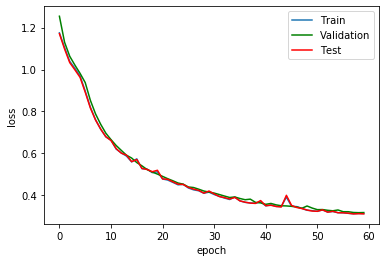

In [222]:
plt.plot(cnn.history['val_loss'])
plt.plot(cnn.history['loss'], 'g')
plt.plot(test_errors['loss'], 'r')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation', 'Test'], loc= 'upper right')

In [164]:
best_epoch = np.argmin(cnn.history['val_loss'])
best_model = sorted(os.listdir())[best_epoch]
CNN.load_weights(best_model)

In [168]:
pred = CNN.predict(test_grayscale)
pred = np.reshape(pred, (pred.shape[0]*pred.shape[1]*pred.shape[2], pred.shape[3]))

In [169]:
test_tetra =[]
for i in range(len(pred)):
    label = pred[i].argmax()
    test_tetra.append(main_colors[label].tolist())
test_tetra = np.array(test_tetra)
test_tetra = np.reshape(test_tetra, (test.shape[0], 32, 32, 3))


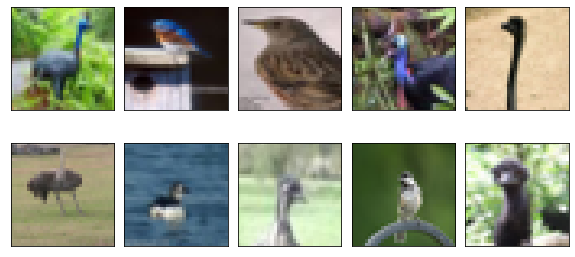

In [204]:
fig = plt.figure(figsize = (10, 5))
fig.subplots_adjust(hspace = 0, wspace = .1)
for i in range(0, 10):
    fig.add_subplot(2, 5, i+1, xticks = [], yticks = [])
    plt.imshow(train[i])

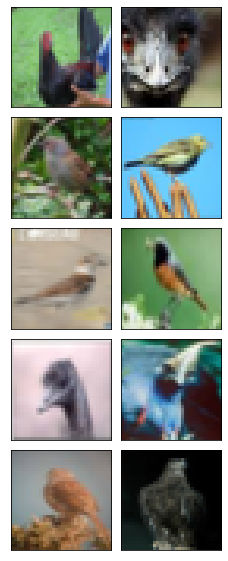

In [217]:
fig_test = plt.figure(figsize = (5, 10))
fig_test.subplots_adjust(hspace = 0.1, wspace = -.35)
for i in range(0, 10):
    fig_test.add_subplot(5, 2, i+1, xticks = [], yticks = [])
    plt.imshow(test[i])

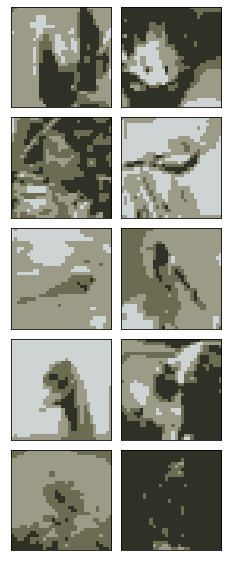

In [218]:
fig_tetra = plt.figure(figsize = (5, 10))
fig_tetra.subplots_adjust(hspace = 0.1, wspace = -.35)
for i in range(0, 10):
    fig_tetra.add_subplot(5, 2, i+1, xticks = [], yticks = [])
    plt.imshow(test_tetra[i].astype(np.uint8))

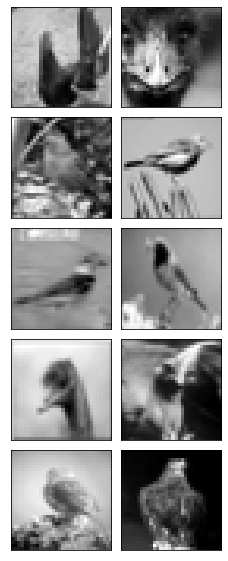

In [219]:
fig_gray = plt.figure(figsize = (5, 10))
fig_gray.subplots_adjust(hspace = 0.1, wspace = -.35)
for i in range(0, 10):
    fig_gray.add_subplot(5, 2, i+1, xticks = [], yticks = [])
    plt.imshow(rgb2gray(test)[i], cmap = 'gray')

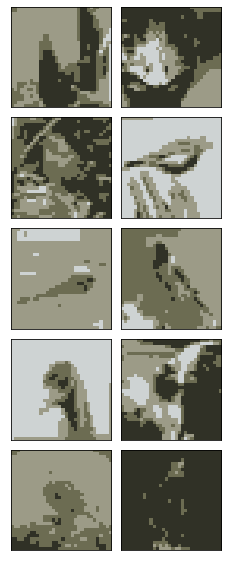

In [220]:
fig_k = plt.figure(figsize = (5, 10))
fig_k.subplots_adjust(hspace = 0.1, wspace = -.35)
for i in range(0, 10):
    fig_k.add_subplot(5, 2, i+1, xticks = [], yticks = [])
    plt.imshow(k_colored[len(train) + i].astype(np.uint8))


# Part2 _ Generative Models for Text

In [2]:
def remove_newlines(sentence):
    new_sentence = re.sub(r'\\r\\n', ' ', sentence)
    return new_sentence

In [3]:
def remove_header(sentence):
    new_sentence = ' '
    if(sentence[:11] == "b'xefxbbxbf"):
        new_sentence = sentence[11:]
    elif(sentence[:10] == "bxefxbbxbf"):
        new_sentence = sentence[10:]
    elif(sentence[:2] == "b'"):
        new_sentence = sentence[2:]
    else:
        pass
    return new_sentence

In [4]:
def remove_end(sentence):
    new_sentence = ' '
    if(sentence[-2:] == " '"):
        new_sentence = sentence[:-2]
    return new_sentence

In [5]:
def to_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


In [6]:
def remove_punct(words):
    new_words = []
    for word in words:
        new_word = re.sub("[^a-zA-Z' ]+", '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

In [7]:
def remove_controls(words):
    new_words = []
    for word in words:
        if(word[:1] != chr(92) and word != ''):
            new_words.append(word)
        else:
            pass
    return new_words

In [8]:
def remove_roman_numerals(words):
    roman_num = ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 
                 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X']
    new_words = []
    for word in words:
        if(word not in roman_num and word != ''):
            new_words.append(word)
        else:
            pass
    return new_words


In [9]:
def to_lower(words):
    new_words =[]
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

In [10]:
def back_to_string(words):
    sentences = []
    text = ' '
    for word in words:
        sentence = ' '.join(word)
        sentences.append(sentence)
    text = ' '.join(sentences)
    return text

In [11]:
def clean_text(text):
    sentences = text.split('.')
    new_words = []
    for sentence in sentences:
        new_sentence = re.sub(r'\\r\\n', ' ', sentence)
        words = new_sentence.split()
        words = remove_controls(words)
        words = to_ascii(words)
        words = remove_roman_numerals(words)
        words = remove_punct(words)
        words = to_lower(words)
        if(len(words) != 0):
            new_words.append(words)
        else:
            pass
    text = back_to_string(new_words)
    text = remove_header(text)
    return text


In [12]:
def unique_alpha(text):
    unique = ''
    for c in text:
        unique = set(c)
    return unique

In [13]:
def scale(text):
    scaled = (text - text.min()) / (text.max() - text.min())
    return scaled

In [14]:
def convert_to_ord(text):
    result = []
    for char in text:
        result.append(ord(char))
    result = pd.Series(result)
    return result


In [15]:
titles = ['MLOE.txt','TAMatter.txt', 'OKEWFSMP.txt', 'TPP.txt', 'THWP.txt', 'TAM.txt', 'AIIMAT.txt']
cleaned_texts = []
for t in titles:
    f = open(t, 'rb')
    s = str(f.read())
    f.close()
    cleaned_texts.append(clean_text(s))

cleaned_texts[6] = cleaned_texts[6][:-15]
cleaned_texts[0] = cleaned_texts[0][:-2]
cleaned_texts[1] = cleaned_texts[1][:-2]
cleaned_texts[2] = cleaned_texts[2][:-2]
cleaned_texts[4] = cleaned_texts[4][:-2]
cleaned_texts[5] = cleaned_texts[5][:-2]

corpus = ' '.join(cleaned_texts)

chars = list(set(corpus))
int_to_char = dict((i, c) for i, c in enumerate(chars))
corpus_converted = convert_to_ord(corpus)
corpus_scaled = scale(corpus_converted)

In [16]:
window = 100
stride = 1

string = []
next_char = []

for i in range(0, (len(corpus_scaled) - window), stride):
    string.append(corpus_scaled[i : (i + window)])
    next_char.append(corpus[(i + window)])

x = np.reshape(string, (len(string), window, 1))
y = OneHotEncoder().fit_transform(np.array(next_char).reshape(-1, 1)).toarray()

In [19]:
memory_units = len(chars)
model = Sequential()
model.add(LSTM(memory_units, input_shape = (x.shape[1], x.shape[2])))
model.add(Dropout(.2))
model.add(Dense(y.shape[1], activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam')
filepath = "weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', mode = 'min')
callbacks_set = [checkpoint]

model.fit(x, y, batch_size = 64, epochs = 60, callbacks = callbacks_set)

Epoch 1/60
4831225/4831225 [==============================] - 2620s 542us/step - loss: 2.5901
Epoch 2/60
4831225/4831225 [==============================] - 2602s 539us/step - loss: 2.5168
Epoch 3/60
4831225/4831225 [==============================] - 2614s 541us/step - loss: 2.4840
Epoch 4/60
4831225/4831225 [==============================] - 3913s 810us/step - loss: 2.6232
Epoch 5/60
4831225/4831225 [==============================] - 2403s 497us/step - loss: 2.4605
Epoch 6/60
4831225/4831225 [==============================] - 2388s 494us/step - loss: 2.4708
Epoch 7/60
4831225/4831225 [==============================] - 2367s 490us/step - loss: 2.4393
Epoch 8/60
4831225/4831225 [==============================] - 2366s 490us/step - loss: 2.4454
Epoch 9/60
4831225/4831225 [==============================] - 2353s 487us/step - loss: 2.4226
Epoch 10/60
4831225/4831225 [==============================] - 2361s 489us/step - loss: 2.4148
Epoch 11/60
4831225/4831225 [==============================

In [21]:
filename = "weights-improvement-47-2.33.hdf5"
model.load_weights(filename)

input_string = "there are those who take mental phenomena naively just as they would physical phenomena this school of psychologists tends not to  emphasize the ojbect"

length = 1000
output = '' 
for i in range(length):
    input_converted = convert_to_ord(input_string[i : (window + i)])
    input_scaled = scale(input_converted)
    x_ = np.array(input_scaled).reshape(1, -1)
    x_ = np.reshape(x_, (1, window, 1))
    pred = model.predict(x_, verbose = 0)
    index = np.argmax(pred)
    result = int_to_char[index]
    output += result
    input_string += result

In [34]:
output

"wznw'hnnnhhnnnnnnw'hehnwznnw'hwehnnnnnznnw'hnwzwwzinjhhnwinhnnnnnnnnnnwinhnnnnnnwiniwnnnnnnnnnzinnhhnnhnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnhnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnw'nnnnnnnnnnnhnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnwznijejnhnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnninnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnhnwnnnhnnnnnnnnnnnhnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnw'nhnnnnnnhnnnnnnnnnonnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnwznejhnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnhnnnnnnnnhnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnw'nnnnnnnw'nnnnnnnnnnnhnnnnnnnnnnnnnnnnnnnnnnnnnnnnnhwznijejnhwznejejnhnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnninnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnenhnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnhnnnnnnnnnnnn'ennn'dnnhhnhnnnnnnnnnnnnnnnnnnnn

In [30]:
model2 = Sequential()
model2.add(LSTM(128, input_shape = (x.shape[1], x.shape[2])))
model2.add(Dropout(.2))
model2.add(Dense(y.shape[1], activation = 'softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer = 'Adam')
filepath2 = "model2/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor = 'loss', mode = 'min')
callbacks_set2 = [checkpoint2]

model2.fit(x, y, batch_size = 64, epochs = 30, callbacks = callbacks_set)

Epoch 1/30
4831225/4831225 [==============================] - 6719s 1ms/step - loss: 2.4276
Epoch 2/30
4831225/4831225 [==============================] - 6848s 1ms/step - loss: 2.1585
Epoch 3/30
4831225/4831225 [==============================] - 7384s 2ms/step - loss: 2.0539
Epoch 4/30
4831225/4831225 [==============================] - 7396s 2ms/step - loss: 1.9960
Epoch 5/30
4831225/4831225 [==============================] - 7405s 2ms/step - loss: 1.9588
Epoch 6/30
4831225/4831225 [==============================] - 7418s 2ms/step - loss: 1.9310
Epoch 7/30
4831225/4831225 [==============================] - 7419s 2ms/step - loss: 2.4369
Epoch 8/30
4831225/4831225 [==============================] - 7125s 1ms/step - loss: 2.7141
Epoch 9/30
4831225/4831225 [==============================] - 9903s 2ms/step - loss: 2.7039
Epoch 10/30
4831225/4831225 [==============================] - 9584s 2ms/step - loss: 2.6022
Epoch 11/30
4831225/4831225 [==============================] - 7489s 2ms/step -

In [31]:
filename2 = "weights-improvement-06-1.93.hdf5"
model2.load_weights(filename2)

input_string2 = "there are those who take mental phenomena naively just as they would physical phenomena this school of psychologists tends not to  emphasize the ojbect"

length = 1000
output2 = '' 
for i in range(length):
    input_converted2 = convert_to_ord(input_string[i : (window + i)])
    input_scaled2 = scale(input_converted)
    x_2 = np.array(input_scaled2).reshape(1, -1)
    x_2 = np.reshape(x_, (1, window, 1))
    pred2 = model2.predict(x_2, verbose = 0)
    index2 = np.argmax(pred2)
    result2 = int_to_char[index2]
    output2 += result2
    input_string2 += result2

In [33]:
output2

"'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''